<a href="https://colab.research.google.com/github/RobBurnap/Bioinformatics-MICR4203-MICR5203/blob/main/notebooks/05_Gene_Expression/02_Hierarchical_Clustering_GeneExpression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# L05 Gene Expression — Hierarchical Clustering of Time-Series RNA-Seq Data

In this notebook, we explore how hierarchical clustering can be used to group genes based on their temporal expression profiles following CO₂ downshift.  
We’ll use the same processed dataset as in the PCA exercise, and examine:
- How to compute pairwise similarity between genes
- How linkage methods form a dendrogram
- How to visualize and interpret gene clusters

**Data:** log₂-transformed fold-change values over five time points  
**Goal:** identify groups of co-expressed genes.

# Mount your Goodgle Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [13]:
!ls "/content/drive/MyDrive/Teaching/BIOINFO4-5203-F25/Data/L05_Gene_Expression"

CO2_downshift.csv
CO2_downshift_formatted.csv
GSE104203_Natural_light_RNAseq_processed.csv
GSE104203_Natural_light_RNAseq_processed.xls
High-Light-Pulse.csv


In [12]:
!ls "/content/drive/MyDrive/Teaching/BIOINFO4-5203-F25/Data"

L02-BLASTp_diversity  L05_Gene_Expression  L05_gene_expression_PCA_clustering


# Import libraries

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler

#Load and Inspect Dataset

In [11]:
# Adjust to your mounted Google Drive path
DATA_DIR = "/content/drive/MyDrive/Teaching/BIOINFO4-5203-F25/Data/L05_Gene_Expression"
input_file = f"{DATA_DIR}/CO2_downshift.csv"

df = pd.read_csv(input_file)
print("Original dataset shape:", df.shape)
display(df.head())

Original dataset shape: (3264, 8)


,UNIQID,Name,gene order,CO2 shift 1 Hour,CO2 shift 3 hour,CO2 shift tpi,CO2 shift 6 hour,CO2 shift 12 hour
0,slr0612,NaN,1,<no data>,0.021,<no data>,<no data>,-0.287
1,slr0613,NaN,2,0.261,-0.024,-0.46,-0.24,-0.605
2,sll0558,ycf53,3,0.064,-0.118,-0.119,-0.071,-0.04
3,sll1214,ycf59,4,-0.293,-0.02,-1.186,-0.362,-0.53
4,sll1213,NaN,5,-0.063,-0.024,0.016,0.218,0.037


#Clean and Prepare Data

In [14]:
# Replace and clean
df = df.replace(["<no data>", "NA", "N/A", ""], np.nan)
df = df.apply(pd.to_numeric, errors="coerce")
df = df.fillna(0)

# Keep only expression columns (skip metadata)
expr_df = df.iloc[:, 3:]   # adjust depending on your file layout
print("Expression matrix:", expr_df.shape)

Expression matrix: (3264, 5)


 #Standardize and Compute Distance Matrix

In [15]:
# Standardize each gene (row) across time points
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(expr_df.values)

# Perform hierarchical clustering (Ward’s linkage)
linkage_matrix = linkage(X_scaled, method='ward')

print("Linkage matrix shape:", linkage_matrix.shape)

Linkage matrix shape: (3263, 4)


#Plot Dendrogram

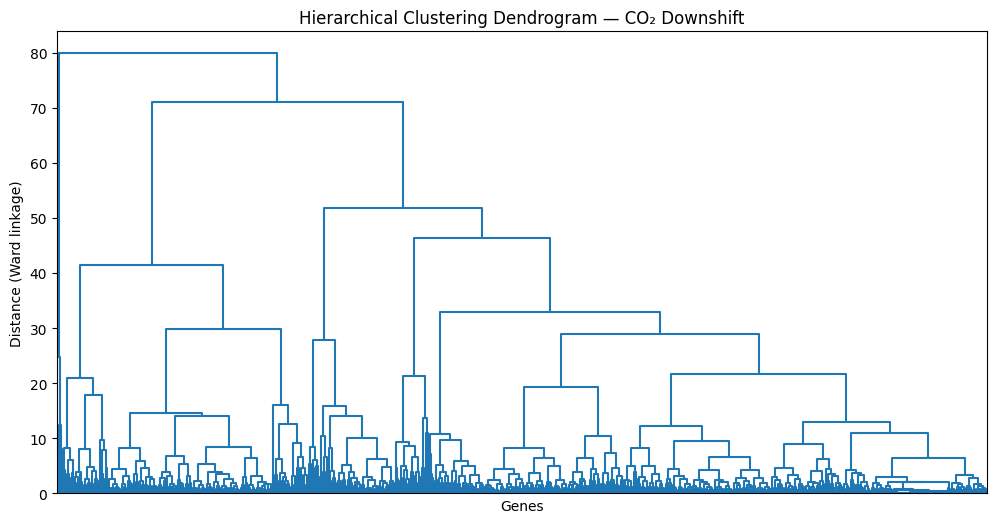

In [16]:
 plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, no_labels=True, color_threshold=0.0)
plt.title("Hierarchical Clustering Dendrogram — CO₂ Downshift")
plt.xlabel("Genes")
plt.ylabel("Distance (Ward linkage)")
plt.show()

#Cluster Assignment

In [17]:
# Cut the tree at a set number of clusters (e.g., 6)
num_clusters = 6
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

df['Cluster'] = clusters
print("Cluster counts:")
print(df['Cluster'].value_counts())

Cluster counts:
Cluster
6    1960
3     706
4     307
2     154
5     115
1      22
Name: count, dtype: int64


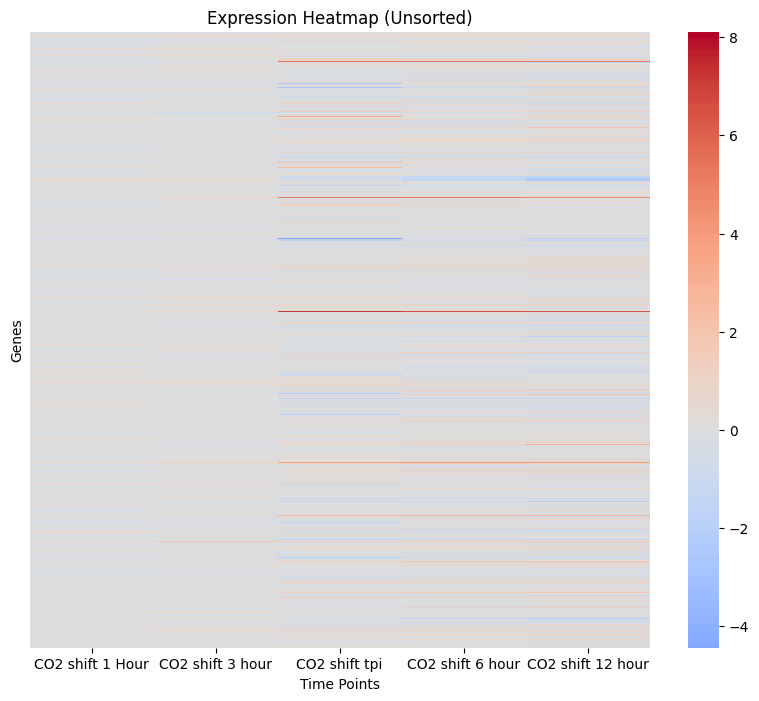

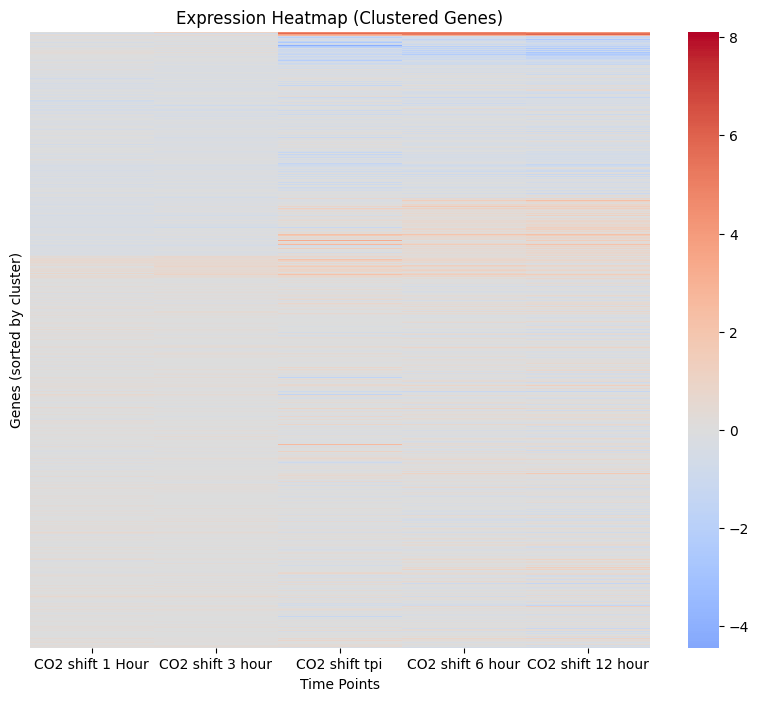

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(expr_df, cmap="coolwarm", center=0, xticklabels=True, yticklabels=False)
plt.title("Expression Heatmap (Unsorted)")
plt.xlabel("Time Points")
plt.ylabel("Genes")
plt.show()

# Sorted by cluster
sorted_df = expr_df.copy()
sorted_df['Cluster'] = clusters
sorted_df = sorted_df.sort_values('Cluster')
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_df.iloc[:, :-1], cmap="coolwarm", center=0, xticklabels=True, yticklabels=False)
plt.title("Expression Heatmap (Clustered Genes)")
plt.xlabel("Time Points")
plt.ylabel("Genes (sorted by cluster)")
plt.show()